In [ ]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless" wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()


Mounted at /content/drive
Current directory: /content/drive/MyDrive/rsna_data


Notebook Color Schemes:


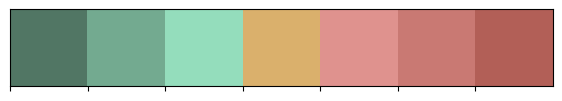

In [ ]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'

my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C",
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [ ]:
train_dicom_tag = pd.read_parquet("train_dicom_tags.parquet")
train_meta = pd.read_csv("train_series_meta.csv")
train = pd.read_csv("train.csv")

In [ ]:
test_dicom_tag = pd.read_parquet("test_dicom_tags.parquet")
test_meta = pd.read_csv("test_series_meta.csv")

In [ ]:
# train_dicom_tag.head()
# train_dicom_tag.columns
join_train_dicom_tag = train_dicom_tag[["PatientID","ImageOrientationPatient","HighBit","PatientPosition","PixelSpacing","RescaleType"]]
split_paths = train_dicom_tag['path'].str.split('/')
join_train_dicom_tag['SeriesNumber'] = split_paths.str[2]

In [ ]:
# train_meta.head()
# train_meta.columns
join_train_meta = train_meta[["patient_id","series_id",'aortic_hu']]

In [ ]:
join_train_meta.shape, join_train_dicom_tag.shape

((4711, 3), (1510373, 7))

In [ ]:
print(join_train_meta.dtypes)
print(join_train_dicom_tag.dtypes)

patient_id      int64
series_id       int64
aortic_hu     float64
dtype: object
PatientID                  object
ImageOrientationPatient    object
HighBit                     int64
PatientPosition            object
PixelSpacing               object
RescaleType                object
SeriesNumber               object
dtype: object


In [ ]:
join_train_meta['patient_id'] = join_train_meta['patient_id'].astype(int)
join_train_meta['series_id'] = join_train_meta['series_id'].astype(int)
join_train_dicom_tag['PatientID'] = join_train_dicom_tag['PatientID'].astype(int)
join_train_dicom_tag['SeriesNumber'] = join_train_dicom_tag['SeriesNumber'].astype(int)

In [ ]:
result_df = pd.merge( join_train_dicom_tag, join_train_meta,
                      left_on=["PatientID","SeriesNumber"],
                      right_on=["patient_id","series_id"])

result_df = result_df.drop(columns=["patient_id", "series_id"])
result_df = result_df.drop_duplicates()
print(result_df.shape)
print("-------------------------------------")

duplicates = result_df[result_df.duplicated(subset=['SeriesNumber'], keep=False)]
print(duplicates.to_string(index=False))
print("-------------------------------------")

# Series number 같은데 다른 수치 달라서 삭제되지 않은 것들 확인 -> 별 차이 없음 -> 그냥 series number별로 하나씩만 남기기로..
result_df = result_df.drop_duplicates(subset=['SeriesNumber'])
print(result_df.shape)

(4722, 8)
-------------------------------------
 PatientID                                                                                      ImageOrientationPatient  HighBit PatientPosition                   PixelSpacing      RescaleType  SeriesNumber  aortic_hu
     13623                                                [0.999982, 0.000000, -0.005988, 0.000000, 1.000000, 0.000000]       15             FFS           [0.741820, 0.741820] Houndsfield Unit         24645      151.0
     13623                                                [0.999982, 0.000000, -0.005987, 0.000000, 1.000000, 0.000000]       15             FFS           [0.741820, 0.741820] Houndsfield Unit         24645      151.0
        43                                                [0.999982, 0.000000, -0.005988, 0.000000, 1.000000, 0.000000]       15             FFS           [0.976990, 0.976990] Houndsfield Unit         24055      127.0
        43                                                [0.999982, 0.000000, -

In [ ]:
result_df['RescaleType'].value_counts()

HU                  2766
nan                 1787
Houndsfield Unit     158
Name: RescaleType, dtype: int64

In [ ]:
result_df = result_df.reset_index(drop=True)
result_df

,PatientID,ImageOrientationPatient,HighBit,PatientPosition,PixelSpacing,RescaleType,SeriesNumber,aortic_hu
0,49954,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",15,FFS,"[0.923, 0.923]",nan,41479,253.0
1,50737,"[1, 0, 0, 0, 1, 0]",11,HFS,"[0.75390625, 0.75390625]",HU,59269,100.0
2,55903,"[1.0, -0.0, 0.0, -0.0, 1.0, 0.0]",15,HFS,"[0.753906, 0.753906]",HU,29738,576.0
3,55903,"[1.0, -0.0, 0.0, -0.0, 1.0, 0.0]",15,HFS,"[0.753906, 0.753906]",HU,5363,246.0
4,51078,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",15,FFS,"[0.652344, 0.652344]",HU,62342,153.0
...,...,...,...,...,...,...,...,...
4706,14790,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",15,FFS,"[0.859375, 0.859375]",HU,7720,282.0
4707,14790,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",15,FFS,"[0.859375, 0.859375]",HU,60494,133.0
4708,9549,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]",15,FFS,"[0.93, 0.93]",nan,36394,245.0
4709,9549,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]",15,FFS,"[0.907, 0.907]",nan,20222,132.0


In [ ]:
parsed_data = []

for item in result_df['ImageOrientationPatient']:
    # 문자열을 리스트로 변환하고 숫자로 파싱
    values = [float(x) for x in item.strip('[]').split(',')]
    parsed_data.append(values)

# 2D 배열을 Pandas DataFrame으로 변환
split_df = pd.DataFrame(parsed_data, columns=['ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3', 'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6'])

# 결과 확인
print(split_df.head(10).to_string(index=False))

 ImageOrientationPatient1  ImageOrientationPatient2  ImageOrientationPatient3  ImageOrientationPatient4  ImageOrientationPatient5  ImageOrientationPatient6
                      1.0                       0.0                       0.0                       0.0                       1.0                       0.0
                      1.0                       0.0                       0.0                       0.0                       1.0                       0.0
                      1.0                      -0.0                       0.0                      -0.0                       1.0                       0.0
                      1.0                      -0.0                       0.0                      -0.0                       1.0                       0.0
                      1.0                       0.0                       0.0                       0.0                       1.0                       0.0
                      1.0                       0.0             

In [ ]:
# 원래 데이터프레임에서 ImageOrientationPatient 열 제거
df1 = result_df.drop(columns=['ImageOrientationPatient'])

# 두 데이터프레임을 인덱스를 기준으로 병합
df1 = pd.concat([df1, split_df], axis=1)

print(df1.head(10).to_string(index=False))

 PatientID  HighBit PatientPosition             PixelSpacing RescaleType  SeriesNumber  aortic_hu  ImageOrientationPatient1  ImageOrientationPatient2  ImageOrientationPatient3  ImageOrientationPatient4  ImageOrientationPatient5  ImageOrientationPatient6
     49954       15             FFS           [0.923, 0.923]         nan         41479      253.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0
     50737       11             HFS [0.75390625, 0.75390625]          HU         59269      100.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0
     55903       15             HFS     [0.753906, 0.753906]          HU         29738      576.0                       1.0                      -0.0                       0.0                      -0.0                       1.0           

In [ ]:
df2 = df1.copy()
df2['PatientPosition'] = df2['PatientPosition'].replace({'FFS': 0, 'HFS': 1})

print(df2.head(10).to_string(index=False))

 PatientID  HighBit  PatientPosition             PixelSpacing RescaleType  SeriesNumber  aortic_hu  ImageOrientationPatient1  ImageOrientationPatient2  ImageOrientationPatient3  ImageOrientationPatient4  ImageOrientationPatient5  ImageOrientationPatient6
     49954       15                0           [0.923, 0.923]         nan         41479      253.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0
     50737       11                1 [0.75390625, 0.75390625]          HU         59269      100.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0
     55903       15                1     [0.753906, 0.753906]          HU         29738      576.0                       1.0                      -0.0                       0.0                      -0.0                       1.0       

In [ ]:
parsed_data = []

for item in result_df['PixelSpacing']:
    # 문자열을 리스트로 변환하고 숫자로 파싱
    values = [float(x) for x in item.strip('[]').split(',')]
    parsed_data.append(values)

# 2D 배열을 Pandas DataFrame으로 변환
split_df = pd.DataFrame(parsed_data, columns=['PixelSpacing1', 'PixelSpacing2'])

# 결과 확인
print(split_df.head(10).to_string(index=False))

 PixelSpacing1  PixelSpacing2
      0.923000       0.923000
      0.753906       0.753906
      0.753906       0.753906
      0.753906       0.753906
      0.652344       0.652344
      0.921875       0.921875
      0.782000       0.782000
      0.782000       0.782000
      0.886719       0.886719
      0.738281       0.738281


In [ ]:
# 원래 데이터프레임에서 PixelSpacing 열 제거
df3 = df2.drop(columns=['PixelSpacing'])

# 두 데이터프레임을 인덱스를 기준으로 병합
df3 = pd.concat([df3, split_df], axis=1)

print(df3.head(10).to_string(index=False))

 PatientID  HighBit  PatientPosition RescaleType  SeriesNumber  aortic_hu  ImageOrientationPatient1  ImageOrientationPatient2  ImageOrientationPatient3  ImageOrientationPatient4  ImageOrientationPatient5  ImageOrientationPatient6  PixelSpacing1  PixelSpacing2
     49954       15                0         nan         41479      253.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0       0.923000       0.923000
     50737       11                1          HU         59269      100.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0       0.753906       0.753906
     55903       15                1          HU         29738      576.0                       1.0                      -0.0                       0.0                      -0.0                       1.0                 

In [ ]:
df4 = df3.copy()
df4['RescaleType'] = np.where(df3['RescaleType'] == 'nan', 0, 1)

print(df4.head(10).to_string(index=False))

 PatientID  HighBit  PatientPosition  RescaleType  SeriesNumber  aortic_hu  ImageOrientationPatient1  ImageOrientationPatient2  ImageOrientationPatient3  ImageOrientationPatient4  ImageOrientationPatient5  ImageOrientationPatient6  PixelSpacing1  PixelSpacing2
     49954       15                0            0         41479      253.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0       0.923000       0.923000
     50737       11                1            1         59269      100.0                       1.0                       0.0                       0.0                       0.0                       1.0                       0.0       0.753906       0.753906
     55903       15                1            1         29738      576.0                       1.0                      -0.0                       0.0                      -0.0                       1.0             

In [ ]:
df4.columns

Index(['PatientID', 'HighBit', 'PatientPosition', 'RescaleType',
       'SeriesNumber', 'aortic_hu', 'ImageOrientationPatient1',
       'ImageOrientationPatient2', 'ImageOrientationPatient3',
       'ImageOrientationPatient4', 'ImageOrientationPatient5',
       'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2'],
      dtype='object')

In [ ]:
df4.to_csv('train_dicom_row_data.csv', index=False)